<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [19]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-06-17 22:31:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolvendo s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Conectando-se a s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 23101 (23K) [text/csv]
Salvando em: “loan_train.csv”

loan_train.csv      100%[===================>]  22,56K  --.-KB/s    em 0,1s    

2020-06-17 22:31:05 (172 KB/s) - “loan_train.csv” salvo [23101/23101]



### Load Data From CSV File  

In [20]:
df = pd.read_csv('loan_train.csv')

In [21]:
df.shape

(346, 10)

### Convert to date time object 

In [22]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seaborn-0.10.1             |             py_0         160 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2020.4.5.1         |           py36_0         159 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.2 MB

The following packages will be UPDATED:

    ca-certificates: 2020.1.1-0         --> 2020.1.1-0        anaconda
    certifi:         2020.4.5.1-py36_0  --> 2020.4.5.1-py36_0 anaconda
    openssl:         1.1.1g-h7b6447c_0  --> 1.1.1g-h7b6447c_0 anaconda
    seaborn:         0.9.0-pyh91

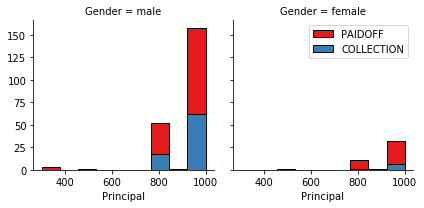

In [23]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

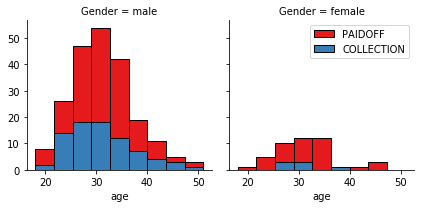

In [6]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

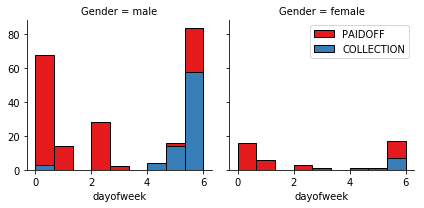

In [24]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [25]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [9]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [26]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [7]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [27]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [28]:
df = df[['Principal','terms','age','Gender','education','loan_status']]

In [ ]:
#removing outliers from the features 'Principal' and 'terms'

In [29]:
df['Principal'].value_counts()

1000    258
800      81
300       3
500       2
900       2
Name: Principal, dtype: int64

In [30]:
df['terms'].value_counts()

30    184
15    148
7      14
Name: terms, dtype: int64

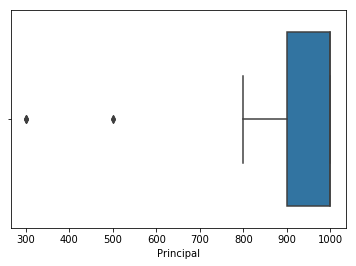

In [31]:
sns.boxplot(df['Principal'])

In [32]:
#This steps replace the values with few occurrences in the features 'Principal' and 'terms' with nan values..
#After the nan values are excluded of the dataset

df['Principal'].replace({300: np.nan, 500:np.nan, 900:np.nan},inplace=True)
df['terms'].replace({7: np.nan},inplace=True)
df.dropna(inplace=True)

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [33]:
df = pd.concat([df,pd.get_dummies(df['education'])], axis=1)
df.drop(['Master or Above'], axis = 1,inplace=True)
df.head()


,Principal,terms,age,Gender,education,loan_status,Bechalor,High School or Below,college
0,1000.0,30.0,45,0,High School or Below,PAIDOFF,0,1,0
1,1000.0,30.0,33,1,Bechalor,PAIDOFF,1,0,0
2,1000.0,15.0,27,0,college,PAIDOFF,0,0,1
3,1000.0,30.0,28,1,college,PAIDOFF,0,0,1
4,1000.0,30.0,29,0,college,PAIDOFF,0,0,1


In [34]:
#excluding the original feature 'education'
df.drop(['education'], axis = 1,inplace=True)

In [35]:
df.head(2)

,Principal,terms,age,Gender,loan_status,Bechalor,High School or Below,college
0,1000.0,30.0,45,0,PAIDOFF,0,1,0
1,1000.0,30.0,33,1,PAIDOFF,1,0,0


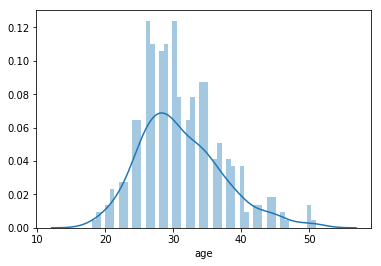

In [37]:
#Checking the distributions of the feature 'age'
sns.distplot(df['age'], bins=50)

In [ ]:
#the following steps transforms the original feature 'age' into value ranges, using k-means to group the 
#values into categories.. 

In [39]:
from sklearn.preprocessing import KBinsDiscretizer

In [40]:
# discretização para o conjunto de treino
disc = KBinsDiscretizer(n_bins=5, encode="onehot-dense", strategy="kmeans")
disc.fit(df[["age"]])
score_bins_uniform = disc.transform(df[["age"]]).astype(np.int)

In [41]:
#the following code gives the limits of each interval 

bin_edges = disc.bin_edges_[0]

In [42]:
# Function to define each interval
def get_interval(bin_idx, bin_edges):
    return f"{np.round(bin_edges[bin_idx], 2):.2f} ⊢ {np.round(bin_edges[bin_idx+1], 2):.2f}"

In [45]:
#variable tha receives a list with the generated intervals

score_intervals_columns = [get_interval(i, bin_edges) for i in range(5)]

print(f"Bins: Kmeans")
print(f"intervalo: #elementos\n")
for i in range(len(disc.bin_edges_[0])-1):
    print(f"{get_interval(i, bin_edges)}: {sum(score_bins_uniform[:, i])}")

Bins: Kmeans
intervalo: #elementos

18.00 ⊢ 25.72: 51
25.72 ⊢ 31.32: 142
31.32 ⊢ 37.00: 89
37.00 ⊢ 43.06: 33
43.06 ⊢ 51.00: 15


In [46]:
# The original dataframe receive the new generated columns, one column for each interval generated.

df = pd.concat([df, pd.DataFrame(score_bins_uniform, columns=score_intervals_columns)], axis=1)

In [47]:
df.head()

,Principal,terms,age,Gender,loan_status,Bechalor,High School or Below,college,18.00 ⊢ 25.72,25.72 ⊢ 31.32,31.32 ⊢ 37.00,37.00 ⊢ 43.06,43.06 ⊢ 51.00
0,1000.0,30.0,45.0,0.0,PAIDOFF,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1000.0,30.0,33.0,1.0,PAIDOFF,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1000.0,15.0,27.0,0.0,PAIDOFF,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1000.0,30.0,28.0,1.0,PAIDOFF,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1000.0,30.0,29.0,0.0,PAIDOFF,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [48]:
#excluding de original feature 'age'
df.drop('age',axis=1,inplace=True)

In [50]:
#the following code transforms the values in the feature 'terms' to 'category' and after, generated new columns
#with values from the original column
df['terms'] = df['terms'].astype('category')
df = pd.concat([df,pd.get_dummies(df['terms'], prefix='terms')], axis=1)

In [51]:
df.drop('terms',axis=1,inplace=True)

In [52]:
df.head(2)

,Principal,Gender,loan_status,Bechalor,High School or Below,college,18.00 ⊢ 25.72,25.72 ⊢ 31.32,31.32 ⊢ 37.00,37.00 ⊢ 43.06,43.06 ⊢ 51.00,terms_15.0,terms_30.0
0,1000.0,0.0,PAIDOFF,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
1,1000.0,1.0,PAIDOFF,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1


In [53]:
df.isnull().sum()

Principal               16
Gender                  16
loan_status             16
Bechalor                16
High School or Below    16
college                 16
18.00 ⊢ 25.72           16
25.72 ⊢ 31.32           16
31.32 ⊢ 37.00           16
37.00 ⊢ 43.06           16
43.06 ⊢ 51.00           16
terms_15.0               0
terms_30.0               0
dtype: int64

In [54]:
#excluding the remaining null values in the dataframe
df.dropna(inplace=True)

In [56]:
#separating the columns for Features and target
features = df.drop('loan_status',axis=1)
target = df['loan_status']

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [58]:
features = preprocessing.StandardScaler().fit(features).transform(features)

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (251, 12) (251,)
Test set: (63, 12) (63,)


In [62]:
#seeking for the best k value

knn = KNeighborsClassifier()

# Create a pipeline
pipe = Pipeline([('knn', knn)])

# Create space of candidate values
search_space = [{'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

In [63]:
# Create grid search 
clf_knn = GridSearchCV(pipe, search_space, cv=5, verbose=0).fit(X_train, y_train)

In [64]:
# Best neighborhood size (k)
clf_knn.best_estimator_.get_params()['knn__n_neighbors']

9

In [65]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_test, clf_knn.predict(X_test)))

Train set Accuracy:  0.7936507936507936


# Decision Tree

In [66]:
from sklearn.tree import DecisionTreeClassifier

In [67]:
clf_tree = DecisionTreeClassifier()

In [68]:
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [69]:
print("Train set Accuracy: ", metrics.accuracy_score(y_test, clf_tree.predict(X_test)))

Train set Accuracy:  0.746031746031746


In [70]:
#creating a pipelin to find the best parameters for the Decision Tree algorithm

pipe = Pipeline(steps=[('dtreeClf', clf_tree)])

# Create lists of parameter for DecisionTreeRegressor
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(dtreeClf__criterion=criterion,
                  dtreeClf__max_depth=max_depth)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)

# Fit the grid search
clf.fit(X_train, y_train)

# View The Best Parameters
#print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
#print(); print(clf.best_estimator_.get_params()['dtreeClf'])

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('dtreeClf',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                 

In [71]:
clf.best_params_

{'dtreeClf__criterion': 'entropy', 'dtreeClf__max_depth': 4}

In [72]:
#decision tree with the best parameters
dc_best = DecisionTreeClassifier(criterion='entropy', max_depth= 4)

In [73]:
dc_best.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [74]:
print("Accuracy decision tree on pipeline: ", metrics.accuracy_score(y_test, dc_best.predict(X_test)))

Accuracy decision tree on pipeline:  0.7619047619047619


# Support Vector Machine

In [75]:
from sklearn.svm import SVC

In [76]:
clf_svm=SVC(gamma='auto',kernel='rbf')

In [77]:
clf_svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [78]:
print("Train set Accuracy: ", metrics.accuracy_score(y_test, clf_svm.predict(X_test)))

Train set Accuracy:  0.7936507936507936


In [79]:
#creating a pipeline to find the best parameters for the SVM algorithm

steps = [('SVM', SVC())]
pipe_svm = Pipeline(steps) # define the pipeline object.
parameteres_svm = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
grid = GridSearchCV(pipe_svm, param_grid=parameteres_svm, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('SVM',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'SVM__C': [0.001, 0.1, 10, 100, 1000000.0],
                         'SVM__gamma': [0.1, 0.01]},
             pre_dispatch

In [80]:
grid.best_params_

{'SVM__C': 0.001, 'SVM__gamma': 0.1}

In [81]:
#SVM with the best parameters
dc_best = SVC(kernel='rbf', C=0.001, gamma=0.1)
dc_best.fit(X_train, y_train)

SVC(C=0.001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [83]:
print("Train set Accuracy: ", metrics.accuracy_score(y_test, dc_best.predict(X_test)))

Train set Accuracy:  0.7936507936507936


# Logistic Regression

In [84]:
from sklearn.linear_model import LogisticRegression

In [85]:
logisticRegr = LogisticRegression()

In [86]:
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [87]:
print("Train set Accuracy: ", metrics.accuracy_score(y_test, logisticRegr.predict(X_test)))

Train set Accuracy:  0.7936507936507936


In [89]:
from sklearn.metrics import log_loss
lg_loan_status_probas = logisticRegr.predict_proba(X_test)
lg_log_loss = log_loss(y_test, lg_loan_status_probas)

In [90]:
lg_log_loss

0.5386867303178496

In [91]:
#creating a pipeline to find the best parameters for the Logistic regression algorithm
pipe_log = Pipeline(steps=[('logistic', logisticRegr)])

# Create a list of values of the regularization parameter
C = np.logspace(-4, 4, 50)

# Create a list of options for the regularization penalty
penalty = ['l1', 'l2']

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(logistic__C=C,
                  logistic__penalty=penalty)

In [92]:
# Create a grid search object
clf_log_reg = GridSearchCV(pipe_log, parameters)

# Fit the grid search
clf_log_reg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                                         

In [93]:
clf_log_reg.best_params_

{'logistic__C': 0.0001, 'logistic__penalty': 'l2'}

In [94]:
print("Train set Accuracy: ", metrics.accuracy_score(y_test, clf_log_reg.predict(X_test)))

Train set Accuracy:  0.7936507936507936


In [95]:
lg_loan_status_probas = clf_log_reg.predict_proba(X_test)
lg_log_loss = log_loss(y_test, lg_loan_status_probas)

In [96]:
lg_log_loss

0.5104971552405112

# Model Evaluation using Test set

In [97]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [13]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-06-18 16:39:32--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolvendo s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Conectando-se a s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 3642 (3,6K) [text/csv]
Salvando em: “loan_test.csv”

loan_test.csv       100%[===================>]   3,56K  --.-KB/s    em 0s      

2020-06-18 16:39:32 (92,0 MB/s) - “loan_test.csv” salvo [3642/3642]



### Load Test set for evaluation 

In [99]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [100]:
#The following steps are necessary to transform the test dataframe with the same transfomations made in the train
#dataframe
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df = test_df[['Principal','terms','age','Gender','education','loan_status']]
test_df = pd.concat([test_df,pd.get_dummies(test_df['education'])], axis=1)
test_df.drop(['Master or Above'], axis = 1,inplace=True)
test_df.head(2)

,Principal,terms,age,Gender,education,loan_status,Bechalor,High School or Below,college
0,1000,30,50,1,Bechalor,PAIDOFF,1,0,0
1,300,7,35,0,Master or Above,PAIDOFF,0,0,0


In [101]:
# discretization of the 'age' feature for the dataset test
disc_train = KBinsDiscretizer(n_bins=5, encode="onehot-dense", strategy="kmeans")
disc_train.fit(test_df[["age"]])
score_bins_uniform = disc_train.transform(test_df[["age"]]).astype(np.int)
bin_edges_train = disc_train.bin_edges_[0]
score_intervals_columns = [get_interval(i, bin_edges_train) for i in range(5)]
print(f"Bins: Kmeans")
print(f"intervalo: #elementos\n")
for i in range(len(disc_train.bin_edges_[0])-1):
    print(f"{get_interval(i, bin_edges_train)}: {sum(score_bins_uniform[:, i])}")

Bins: Kmeans
intervalo: #elementos

20.00 ⊢ 26.95: 10
26.95 ⊢ 32.47: 22
32.47 ⊢ 38.93: 17
38.93 ⊢ 45.17: 3
45.17 ⊢ 50.00: 2


In [102]:
test_df = pd.concat([test_df, pd.DataFrame(score_bins_uniform, columns=score_intervals_columns)], axis=1)

In [103]:
#transformation of the feature 'terms'
test_df['terms'] = test_df['terms'].astype('category')
test_df = pd.concat([test_df,pd.get_dummies(test_df['terms'])], axis=1)
test_df.drop('terms',axis=1,inplace=True)

In [104]:
#defining features and the target column 
Features_test = test_df.drop('loan_status',axis=1)
target_test = test_df['loan_status']

In [106]:
Features_test.drop(['age','education',7],axis=1,inplace=True)

In [107]:
#standardizatioin of the features
Features_test = preprocessing.StandardScaler().fit(Features_test).transform(Features_test)

## KNN - predictions

In [119]:
#jaccard
knn_jaccard = jaccard_similarity_score(target_test, clf_knn.predict(Features_test))
round(knn_jaccard,6)

0.759259

In [120]:
#f1_score
knn_f1_score = f1_score(target_test, clf_knn.predict(Features_test), average='weighted')
round(knn_f1_score,6)

0.671764

## Decision tree - predictions

In [118]:
#jaccard
decision_tree_jaccard = jaccard_similarity_score(target_test, clf_tree.predict(Features_test))
round(decision_tree_jaccard,6)

0.648148

In [121]:
#f1_score
decision_tree_f1_score = f1_score(target_test, clf_tree.predict(Features_test), average='weighted')
round(decision_tree_f1_score,6)

0.603661

## SVM - predictions

In [122]:
#jaccard
decision_tree_jaccard = jaccard_similarity_score(target_test, dc_best.predict(Features_test))
round(decision_tree_jaccard,6)

0.740741

In [123]:
#f1_score
decision_tree_f1_score = f1_score(target_test, dc_best.predict(Features_test), average='weighted')
round(decision_tree_f1_score,6)

0.630418

## Logistic regression - predictions

In [124]:
#jaccard
lr_tree_jaccard = jaccard_similarity_score(target_test, clf_log_reg.predict(Features_test))
round(lr_tree_jaccard,6)

0.740741

In [125]:
#f1_score
lr_tree_f1_score = f1_score(target_test, clf_log_reg.predict(Features_test), average='weighted')
round(lr_tree_f1_score,6)

0.630418

In [127]:
#Log loss
lg_loan_status_probas = clf_log_reg.predict_proba(Features_test)
lg_log_loss = log_loss(target_test, lg_loan_status_probas)
round(lg_log_loss,6)

0.575058

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard  | F1-score  | LogLoss  |
|--------------------|----------|-----------|----------|
| KNN                | 0.759259 | 0.671764  | NA       |
| Decision Tree      | 0.648148 | 0.603661  | NA       |
| SVM                | 0.740741 | 0.630418  | NA       |
| LogisticRegression | 0.740741 | 0.630418  | 0.575058 |

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>